# A-Band Simulation and Fitting Using MATS
* Loads packages
* Defines Spectra and Dataset
* Generates parameter and baseline linelists
* Fits Data

In [1]:
## Multi- Spectrum Fitting by Segment

import numpy as np
#import numpy.ma as ma
import pandas as pd
import qgrid
import os
#from lmfit import minimize, Parameters, report_fit, Model, Minimizer
#from lmfit.models import GaussianModel, LinearModel, Model, VoigtModel
import matplotlib.pyplot as plt
from matplotlib import gridspec
#from scipy import interpolate

import sys
sys.path.append(r'C:\Users\ema3\Documents\MATS\MATS')# set location of HAPI.py module
%matplotlib inline
from hapi import *
from MATS import *

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")


HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


## Simulate Spectrum

If you are simulating spectra, opposed to reading them in from a file , then you can use the MATS.simulate_spectrum() function.

When simulating spectra, the first step is to read in the reference line list. Generation of this line list is described in the Generating Parameter Line lists page. The following code reads in the reference line list as a pandas dataframe, then resets the working directory.

Just as you would do if reading in the experimental spectrum, this example defines some common simulation and fit variables. In addition to variables defined above, the minimum and maximum wavenumbers for the simulation and the simulation wavenumber spacing are defined. The baseline is defined by a polynomial where the array index is the parameter coefficient order, such that the [1, 0] would correspond to a linear baseline with a slope of 0 and an offset of 1.

The MATS.simulate_spectrum() function also allows for error to be added in the following ways:

* to the absorption axis through signal-to-noise ratio (SNR). The SNR is implemented by adding gaussian noise to the spectra such that the (maximum alpha - minimum alpha) / noise is equal to the set SNR.

* to the wavenumber axis through the wave_err parameter. The wavenumber error is implemented by adding a gaussian noise error of the specified magnitude to the wavenumber axis.

* to the mole fraction through the molefraction_err parameter. The molefraction error is implemented as a percent error bias on each (could enter a negative percent error to get negative offset). This mimics the maximum impact that a constant error in sample mole fraction would have.

* to the temperature/pressure through the temperature_err and pressure_err dictionaries. In experiments there are generally two type of errors with pressure and temperature measurements. The first is a constant bias in the reading. The second type of error is an actual change in the pressure/temperature during the collection of the spectrum. To account for both error types the pressure_err and temperature_err are dictionaries, where the keys correspond to ‘bias/per_bias’ (bias for temperature and per_bias for pressure), function (allows ‘linear’ or ‘sine’), and params. If the function is ‘linear’ then the param keys are ‘m’ and ‘b’ corresponding to the slope and interecept. If the function is ‘sine’ then the param keys are ‘amp’, ‘freq’, and ‘phase’ corresponding to the amplitude, period, and phase of the sine function. For both temperature and pressure, the pressure/temperature recorded in the simulated spectra output include the average pressure or temperature over the segment (analogous to the frequency of the pressure/temperature measurement in an experiment) and does not include the bias in pressure/temperature as this is would be an unknown in an experiment.

These parameters and the additional settings for filenames and number of segments can be used to call the MATS.simulate_spectrum() function setting the output equal to a variable as was done when the MATS.Spectrum was used. This makes it simple to transition code from analysis of experimental spectra to error analysis through simulations.

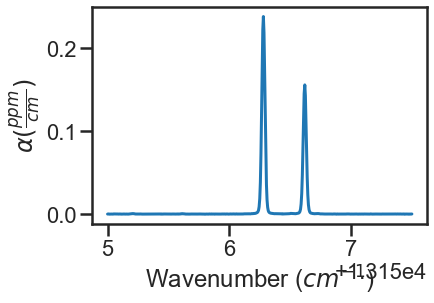

In [2]:
#Read in Possible linelists
hapi = r'C:\Users\ema3\Documents\MATS\MATS\Linelists'
os.chdir(hapi)
PARAM_LINELIST = pd.read_csv('O2_ABand_Drouin_2017_linelist.csv')

path = r'C:\Users\ema3\Documents\MATS\MATS\Examples\A-Band - Synthetic Spectra'
os.chdir(path)

#Generic Fit Parameters
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
sample_molefraction = {7 :0.002022}
wave_min = 13155 #cm-1
wave_max = 13157.5 #cm-1
wave_space = 0.005 #cm-1
baseline_terms = [0] #polynomial baseline coefficients where the index is equal to the coefficient order



#Error Sources
##SNR
SNR = 4000

## Wavenumber - adds gaussian noise of given absolute magniture
wave_error = 1e-4

## Temperature
'''
possible keys include 'bias', 'function', and 'params'.  
The bias indicates the absolute bias in Celsius of the temperature reading, which will be added to the input temperature.  
Function can be 'linear' with params 'm' and 'b' or 'sine' with parameters 'amp', 'freq', and 'phase'.  
These define a function that is added to both the bias and set temperature as a function of the wavenumber. 
Note: if 'function' key is not equal to None, then there also needs to be a params key to define the function.
'''
temperature_err =  {'bias': 0.01, 'function': None, 'params': {}}

## Pressure
'''
possible keys include bias, function, and params.  
The bias indicates the percent bias in of the pressure reading, which will be added to the input pressure.  
Function can be 'linear' with params 'm' and 'b' or 'sine' with parameters 'amp', 'freq', and 'phase'.  
These define a function that is added to both the bias and set pressure as a function of the wavenumber. 
Note: if 'function' key is not equal to None, then there also needs to be a params key to define the function.
'''
pressure_err = {'per_bias': 0.01, 'function': None, 'params': {}}
##Mole Fraction
'''
percent error in the mole fraction of each molecule to be simulated in the spectrum
'''
molefraction_err = {7:0.01}


spec_1 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, temperature_err = temperature_err, pressure = 25, 
                        pressure_err = pressure_err, 
                        wing_cutoff = 50,  wing_method = 'wing_cutoff', filename = '25_torr', molefraction = sample_molefraction, molefraction_err = molefraction_err,
                        natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1)
spec_2 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, temperature_err = temperature_err, pressure = 50, 
                        pressure_err = pressure_err, 
                        wing_cutoff = 50,  wing_method = 'wing_cutoff', filename = '50_torr', molefraction = sample_molefraction, molefraction_err = molefraction_err,
                        natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1)
spec_3 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, temperature_err = temperature_err, pressure = 100, 
                        pressure_err = pressure_err, 
                        wing_cutoff = 50,  wing_method = 'wing_cutoff', filename = '100_torr', molefraction = sample_molefraction, molefraction_err = molefraction_err,
                        natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1)
spec_4 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, temperature_err = temperature_err, pressure = 200, 
                        pressure_err = pressure_err, 
                        wing_cutoff = 50,  wing_method = 'wing_cutoff', filename = '200_torr', molefraction = sample_molefraction, molefraction_err = molefraction_err,
                        natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1)





spec_1.plot_wave_alpha()



## Generate a Dataset

The procedure for analysis for both simulating and loading spectrum are the same from this point forward. The next step is to combine all desired MATS.Spectrum objects into a MATS.Dataset object, where we give the dataset a name. The order of polynomial to use for the baseline fit is also defined

The MATS.Dataset class contains a function to generate a baseline line list, analogous to the one for the parameter line list done outside of this example, based on the order of the baseline fit, etalons, molecules, x-shift parameters, and segments as defined by both the spectrum and dataset objects.

In [3]:
#Add all spectrum to a Dataset object
SPECTRA = Dataset([spec_1, spec_2, spec_3, spec_4], 'Line Intensity', PARAM_LINELIST)

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()


## Generate Fit Parameter Files

The next section of code uses the MATS.Generate_FitParam_File class to define what line shape to use for the initial fits, whether to use line mixing, the minimum line intensity to fit a line, mimimum intensity to included in the simulation, and for each line parameter whether that parameter is going to be constrained across all spectra or whether there will be a parameter for each spectrum (multi-spectrum vs single-spectrum fits) on a parameter by parameter basis. In the example below, the SDVP line profile without line mixing will be used to fit lines with line intensities greater than 1e-24 with no parameters floated.

The next step is to generate fit parameter and baseline line lists that include columns that specify whether that parameter should be varied during fitting, in addition to adding error columns for the fit error for each parameter. For the following example the line centers, line intensities, collisional half-widths, and speed-dependent broadening terms will be floated for all main oxygen isotopes for lines where the line intensity is greater than 1e-24. None of the baseline parameters are floated


These functions will generate .csv files corresponding to these selections, which are read in by the MATS.Fit_DataSet class instantiation. When simulating spectra, if you don't adjust the baseline and parameter line lists, then your simulated variables are equal to your initial guesses.  This can lead to a local minimum where the fit will not move from the initial guesses.  The last segment of the code shows an example where the Parameter line list file and random uncertainties from the simulated values are applied and then the Parameter line list file is resaved.

In [4]:
os.chdir(path)
# Set-up for Fitting
#lineprofile = 'NGP' #VP, SDVP, NGP, SDNGP, HTP


  

FITPARAMS = Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = True, sw_constrain = True, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:False, 2:False, 3:False}}, vary_sw = {7:{1:False, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = False, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= False, vary_etalon_period= False, vary_etalon_phase= False, 
                                         vary_pressure = False, vary_temperature = False)



Parameter_LineList = pd.read_csv('Parameter_LineList.csv', index_col = 0)


for index in Parameter_LineList[(Parameter_LineList['sw']>1) & (Parameter_LineList['nu']<wave_max) & (Parameter_LineList['nu']>wave_min)].index.unique():
    Parameter_LineList.loc[Parameter_LineList.index == index, 'nu'] = Parameter_LineList[Parameter_LineList.index == index]['nu'].values[0] + np.random.normal(loc = 0, scale =0.005) #adjust by random number scale 0.005 cm-1
    Parameter_LineList.loc[Parameter_LineList.index == index, 'sw'] = Parameter_LineList[Parameter_LineList.index == index]['sw'].values[0]*(1 + np.random.normal(loc = 0, scale =0.01)) # adjust by random amount at 1% scale
    Parameter_LineList.loc[Parameter_LineList.index == index, 'gamma0_air'] = Parameter_LineList[Parameter_LineList.index == index]['gamma0_air'].values[0]*(1 + np.random.normal(loc = 0, scale =0.01)) # adjust by random amount at 1% scale
    Parameter_LineList.loc[Parameter_LineList.index == index, 'delta0_air'] = Parameter_LineList[Parameter_LineList.index == index]['delta0_air'].values[0]*(1 + np.random.normal(loc = 0, scale =0.02)) # adjust by random amount at 2% scale
    Parameter_LineList.loc[Parameter_LineList.index == index, 'SD_gamma_air'] = Parameter_LineList[Parameter_LineList.index == index]['SD_gamma_air'].values[0]*(1 + np.random.normal(loc = 0, scale =0.1)) # adjust by random amount at 10% scale

Parameter_LineList.to_csv('Parameter_LineList.csv')

## Fit Dataset

Instantiating the MATS.Fit_DataSet class reads in the information from the baseline and parameter linelists generated in the previous step. The example below iterates on a fit, where in the first iteration no parameters are floated, in the second iteration the line centers and line intensities are floated, and in the final iteration the rest of the non-zero line shape parameters are floated.  Sometimes it is not possible to float all parameters at the same time, specifically with poor initial guesses for line center.  In that case an iterative approach like this is advantageous.


The iteration could also be applied to the lmfit parameter object by setting the the vary term, opposed to through the Parameter_LineList.  In that approach the final Parameter_LineList would have the standard uncertainities and fit values saved, but wouldn't necessarily have the parameter_vary column appropriately set.

ITERATION 0


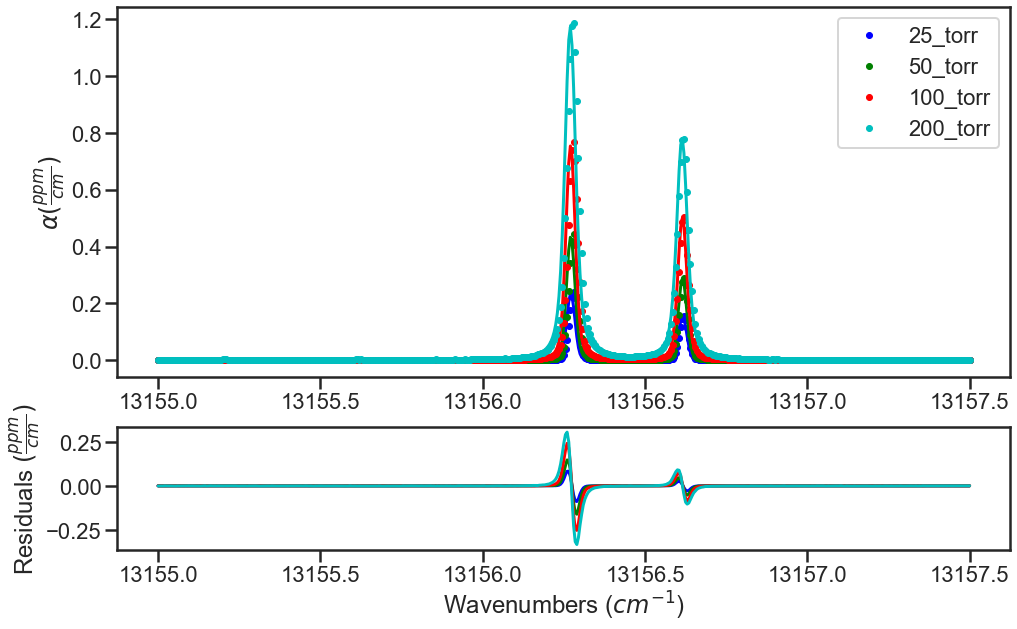

ITERATION 1


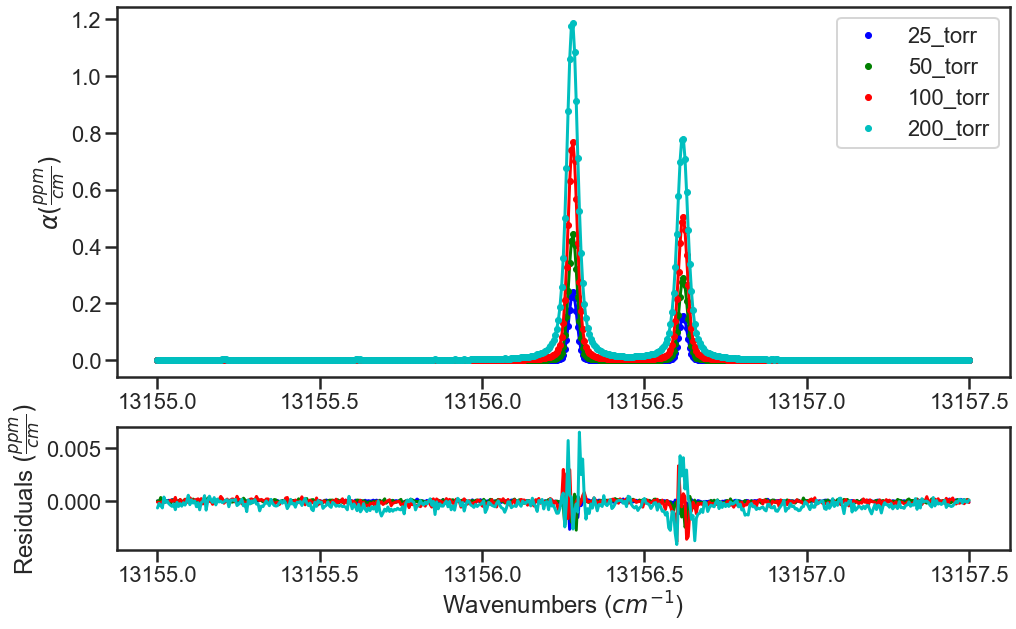

ITERATION 2


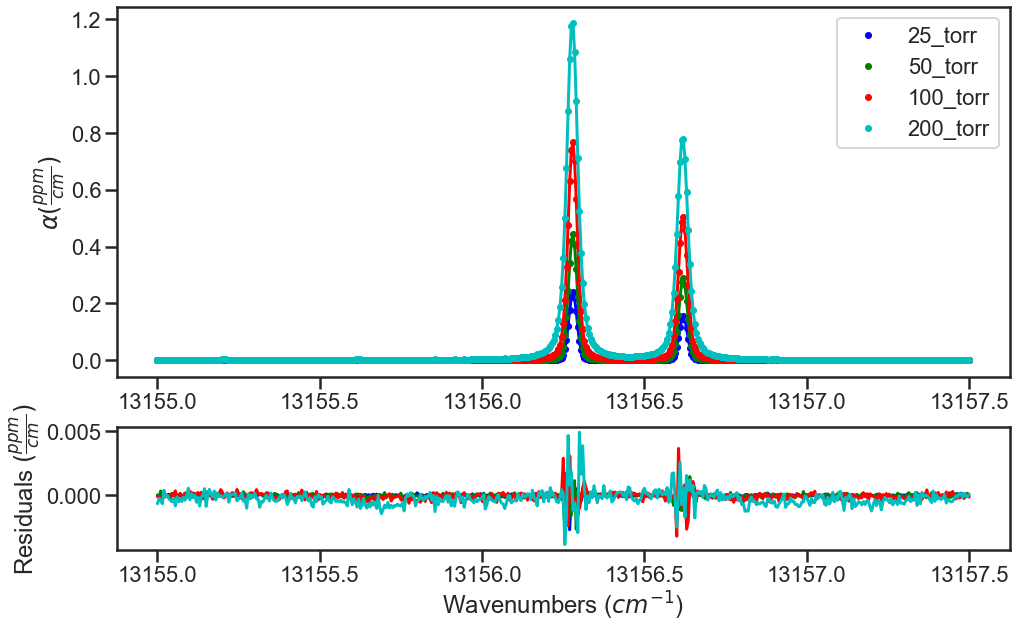

In [5]:
os.chdir(path)

iteration = 0
while iteration <= 2:
    print ('ITERATION ' + str(iteration))
    if iteration == 1:
        Parameter_LineList = pd.read_csv('Parameter_LineList.csv', index_col = 0)
        Parameter_LineList.loc[(Parameter_LineList['sw']>1) & (Parameter_LineList['nu']<wave_max) & (Parameter_LineList['nu']>wave_min), 'nu_vary'] = True
        Parameter_LineList.loc[(Parameter_LineList['sw']>1) & (Parameter_LineList['nu']<wave_max) & (Parameter_LineList['nu']>wave_min), 'sw_vary'] = True
        Parameter_LineList.to_csv('Parameter_LineList.csv')
    if iteration ==2:
        Parameter_LineList = pd.read_csv('Parameter_LineList.csv', index_col = 0)
        Parameter_LineList.loc[(Parameter_LineList['sw']>1) & (Parameter_LineList['nu']<wave_max) & (Parameter_LineList['nu']>wave_min), 'gamma0_air_vary'] = True
        Parameter_LineList.loc[(Parameter_LineList['sw']>1) & (Parameter_LineList['nu']<wave_max) & (Parameter_LineList['nu']>wave_min), 'delta0_air_vary'] = True
        Parameter_LineList.loc[(Parameter_LineList['sw']>1) & (Parameter_LineList['nu']<wave_max) & (Parameter_LineList['nu']>wave_min), 'SD_gamma_air_vary'] = True
        Parameter_LineList.to_csv('Parameter_LineList.csv')
    
    
    fit_data = Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity)
    params = fit_data.generate_params()
    result = fit_data.fit_data(params, wing_cutoff = 25, wing_wavenumbers = 1)
    fit_data.residual_analysis(result, indv_resid_plot=False)
    fit_data.update_params(result)
    SPECTRA.generate_summary_file(save_file = True)
    SPECTRA.plot_model_residuals()
    iteration+=1


